### 1. Setup and Data Loading

First, let's import the necessary libraries and load our training and testing datasets.

### 2. Exploratory Data Analysis (EDA)

Let's visualize the target variables `Y1` and `Y2` over the 'time' column to understand their distributions and look for any apparent trends or seasonality.

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

sns.set_style('whitegrid')

train_df = pd.read_csv('data/train.csv')
train_new = pd.read_csv('data/train_new.csv')
train_df = pd.concat([train_df, train_new], axis=1)

test_df = pd.read_csv('data/test.csv')
test_new = pd.read_csv('data/test_new.csv')
test_df = pd.concat([test_df, test_new], axis=1)

train_df.fillna({'O': train_df['O'].median()}, inplace=True)
test_df.fillna({'O': test_df['O'].median()}, inplace=True)

train_df.fillna({'P': train_df['P'].mode()[0]}, inplace=True)
test_df.fillna({'P': test_df['P'].mode()[0]}, inplace=True)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nTraining data head:")
train_df.tail()

### 3. Feature Engineering

To help our model understand the time-series nature of the data, we will create two types of features:
- **Lag Features:** The value of a feature from a previous time step (e.g., the value of feature 'A' 1 step ago).
- **Rolling Window Features:** Aggregations (like mean or standard deviation) over a recent window of time (e.g., the average of feature 'A' over the last 10 time steps).

In [ ]:
def create_features(df):
    """Creates time-series features from the original data."""
    df_featured = df.copy()

    original_features = [col for col in df.columns if col not in ['time', 'id', 'Y1', 'Y2']]

    # --- Lists of Features for Different Transformations ---
    # These were identified as important in your initial analysis
    momentum_features = ['A', 'K', 'B', 'G', 'M', 'J']
    rolling_features = ['A', 'B', 'G', 'K', 'M', 'J', 'E', 'H', 'D', 'I']

    # 1. Lag Features (Original)
    for col in original_features:
        df_featured[f'{col}_lag_1'] = df_featured[col].shift(1)

    # 2. Lag Differences (Momentum Features) - NEW
    # Captures the rate of change from previous periods
    for col in momentum_features:
        for lag in [1, 3, 5]:
            df_featured[f'{col}_diff_{lag}'] = df_featured[col].diff(lag)

    # 3. Rolling Window Features - EXPANDED
    for window in [10, 20, 50]:
        for col in rolling_features:
            df_featured[f'{col}_rolling_mean_{window}'] = df_featured[col].rolling(window=window).mean()
            df_featured[f'{col}_rolling_std_{window}'] = df_featured[col].rolling(window=window).std()
            # Add min and max to capture the range within the window - NEW
            if window == 20: # Only for one window to avoid too many features at once
                df_featured[f'{col}_rolling_max_{window}'] = df_featured[col].rolling(window=window).max()
                df_featured[f'{col}_rolling_min_{window}'] = df_featured[col].rolling(window=window).min()


    # 4. Exponentially Weighted Moving Averages (EWMA) - NEW
    # Gives more weight to recent observations
    for col in rolling_features:
        for span in [10, 50]:
             df_featured[f'{col}_ewma_{span}'] = df_featured[col].ewm(span=span, adjust=False).mean()


    # 5. Interaction Features (Original)
    epsilon = 1e-6
    df_featured['G_div_M'] = df_featured['G'] / (df_featured['M'] + epsilon)
    df_featured['G_x_J'] = df_featured['G'] * df_featured['J']
    df_featured['A_div_K'] = df_featured['A'] / (df_featured['K'] + epsilon)
    df_featured['A_x_K'] = df_featured['A'] * df_featured['K']

    # --- TIME-INTERACTION FEATURES (Original) ---
    df_featured['time_feature'] = df_featured['time'] # Keep time as a feature
    time_interaction_features = ['A', 'K', 'B', 'G', 'M', 'E', 'J', 'H', 'D', 'I']
    if 'time_feature' in df_featured.columns:
        for col in time_interaction_features:
            df_featured[f'{col}_x_time'] = df_featured[col] * df_featured['time_feature']

    return df_featured

# To ensure consistency, we combine train and test sets for feature engineering
combined_df = pd.concat([train_df.drop(['Y1', 'Y2'], axis=1), test_df], ignore_index=True)
combined_featured_df = create_features(combined_df)

# Separate back into train and test sets
train_featured_df = combined_featured_df.iloc[:len(train_df)]
test_featured_df = combined_featured_df.iloc[len(train_df):]

# Add the target variables back to the training set
train_featured_df['Y1'] = train_df['Y1'].values
train_featured_df['Y2'] = train_df['Y2'].values

# The feature engineering process creates NaNs at the beginning of the dataset.
# We will fill them with the median value of each column.
train_featured_df.fillna(train_featured_df.median(), inplace=True)
test_featured_df.fillna(test_featured_df.median(), inplace=True)

print("Shape of featured training data:", train_featured_df.shape)
print("Shape of featured test data:", test_featured_df.shape)
train_featured_df.head()

Shape of featured training data: (80000, 177)
Shape of featured test data: (15996, 175)


/var/folders/rl/29fk2ndx1nzf2tjbxh8hbx840000gn/T/ipykernel_60002/1410549019.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured[f'{col}_rolling_mean_{window}'] = df_featured[col].rolling(window=window).mean()
/var/folders/rl/29fk2ndx1nzf2tjbxh8hbx840000gn/T/ipykernel_60002/1410549019.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featured[f'{col}_rolling_std_{window}'] = df_featured[col].rolling(window=window).std()
/var/folders/rl/29fk2ndx1nzf2tjbxh8hbx840000gn/T/ipykernel_60002/1410549019.py:23: Performan

,time,A,B,C,D,E,F,G,H,I,...,sin_time_30,cos_time_30,sin_time_60,cos_time_60,sin_time_100,cos_time_100,sin_time_365,cos_time_365,Y1,Y2
0,0,0.207366,-0.159951,-0.634176,-0.580962,-0.266505,0.060173,-0.475257,-1.486516,-0.332594,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,-0.935902,-0.310081
1,1,0.188828,-0.265508,0.042143,-0.550442,-0.132319,-0.185219,0.028295,0.093210,-0.518139,...,0.207912,0.978148,0.104528,0.994522,0.062791,0.998027,0.017213,0.999852,-0.089707,-0.305374
2,2,-0.144261,-0.577142,-0.214634,-0.747391,-0.184255,-0.464831,-0.085181,0.700449,-0.603438,...,0.406737,0.913545,0.207912,0.978148,0.125333,0.992115,0.034422,0.999407,-0.077855,-0.631485
3,3,0.208982,-0.310449,0.513708,-0.562868,0.742308,-0.305487,0.762246,1.363020,-0.384575,...,0.587785,0.809017,0.309017,0.951057,0.187381,0.982287,0.051620,0.998667,0.941271,-0.535212
4,4,0.093320,-0.358156,0.173188,-0.687296,-0.161461,-0.116062,-0.245748,0.863372,-0.655588,...,0.743145,0.669131,0.406737,0.913545,0.248690,0.968583,0.068802,0.997630,-0.039582,-0.490561


In [12]:
# Define features (X) and targets (y)
features = [col for col in train_featured_df.columns if col not in ['time', 'id', 'Y1', 'Y2']]
X = train_featured_df[features]
y1 = train_featured_df['Y1']
y2 = train_featured_df['Y2']
X_test = test_featured_df[features]

print(f"Using {len(features)} features for training.")

# LightGBM Model Parameters (can be tuned)
# Note: We remove 'metric' from here and pass it directly to the .fit() method.

lgbm_params_y1 = {
    'objective': 'regression_l1', 'verbose': -1, 'n_jobs': -1, 'seed': 42,
    'n_estimators': 928, 'learning_rate': 0.0364, 'feature_fraction': 0.588,
    'bagging_fraction': 0.922, 'bagging_freq': 3, 'lambda_l1': 0.0289,
    'lambda_l2': 8.68e-08, 'num_leaves': 64
}

lgbm_params_y2 = {
    'objective': 'regression_l1', 'verbose': -1, 'n_jobs': -1, 'seed': 42,
    'n_estimators': 910, 'learning_rate': 0.0549, 'feature_fraction': 0.545,
    'bagging_fraction': 0.970, 'bagging_freq': 2, 'lambda_l1': 1.55e-06,
    'lambda_l2': 0.0074, 'num_leaves': 75
}

# A solid set of starting parameters for XGBoost
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist', # Faster training
}


# --- 2. Final Validation with Ensemble Model ---
print("\n--- Running final validation with LGBM + XGBoost Ensemble ---")
tscv_final = TimeSeriesSplit(n_splits=5)
scores_y1, scores_y2 = [], []

for fold, (train_index, val_index) in enumerate(tscv_final.split(X), 1):
    print(f"--- Fold {fold}/5 ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]
    y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

    # --- Y1 Models ---
    # Train LGBM for Y1
    lgbm_y1 = lgb.LGBMRegressor(**lgbm_params_y1)
    lgbm_y1.fit(X_train, y1_train, eval_set=[(X_val, y1_val)], callbacks=[lgb.early_stopping(100, verbose=False)])
    lgbm_preds_y1 = lgbm_y1.predict(X_val)

    # Train XGBoost for Y1
    xgb_y1 = xgb.XGBRegressor(callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)], **xgb_params)
    xgb_y1.fit(X_train, y1_train, eval_set=[(X_val, y1_val)], verbose=False)
    xgb_preds_y1 = xgb_y1.predict(X_val)
    
    # Ensemble predictions for Y1
    ensemble_preds_y1 = (lgbm_preds_y1 * 0.4) + (xgb_preds_y1 * 0.6)
    r2_y1 = r2_score(y1_val, ensemble_preds_y1)
    scores_y1.append(r2_y1)
    print(f"Ensemble Y1 R² for fold {fold}: {r2_y1:.4f}")

    # --- Y2 Models ---
    # Train LGBM for Y2
    lgbm_y2 = lgb.LGBMRegressor(**lgbm_params_y2)
    lgbm_y2.fit(X_train, y2_train, eval_set=[(X_val, y2_val)], callbacks=[lgb.early_stopping(100, verbose=False)])
    lgbm_preds_y2 = lgbm_y2.predict(X_val)

    # Train XGBoost for Y2
    xgb_y2 = xgb.XGBRegressor(callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)], **xgb_params)
    xgb_y2.fit(X_train, y2_train, eval_set=[(X_val, y2_val)], verbose=False)
    xgb_preds_y2 = xgb_y2.predict(X_val)

    # Ensemble predictions for Y2
    ensemble_preds_y2 = (lgbm_preds_y2 * 0.4) + (xgb_preds_y2 * 0.6)
    r2_y2 = r2_score(y2_val, ensemble_preds_y2)
    scores_y2.append(r2_y2)
    print(f"Ensemble Y2 R² for fold {fold}: {r2_y2:.4f}")

# --- Validation Summary ---
print("\n--- Ensemble Validation Summary ---")
print(f"Average Ensemble Y1 R²: {np.mean(scores_y1):.4f} +/- {np.std(scores_y1):.4f}")
print(f"Average Ensemble Y2 R²: {np.mean(scores_y2):.4f} +/- {np.std(scores_y2):.4f}")
print(f"Expected Final Score from Ensemble: {np.mean((np.mean(scores_y1), np.mean(scores_y2))):.4f}")

# --- Final Model Training on ALL training data ---
print("\n--- Training final models on all data for submission ---")
# Train final model for Y1
# Re-add metric to params for final training, as no callbacks are used.
final_params_y1 = lgbm_params_y1.copy()
final_params_y1['metric'] = 'r2'
final_model_y1 = lgb.LGBMRegressor(**final_params_y1)
final_model_y1.fit(X, y1)
print("Final Y1 model trained.")

# Train final model for Y2
final_params_y2 = lgbm_params_y2.copy()
final_params_y2['metric'] = 'r2'
final_model_y2 = lgb.LGBMRegressor(**final_params_y2)
final_model_y2.fit(X, y2)
print("Final Y2 model trained.")

# Train model for the XGBoost part of the ensemble
final_xgb_y1 = xgb.XGBRegressor(**xgb_params)
final_xgb_y1.fit(X, y1, verbose=False)
print("Final XGBoost Y1 model trained.")

final_xgb_y2 = xgb.XGBRegressor(**xgb_params)
final_xgb_y2.fit(X, y2, verbose=False)
print("Final XGBoost Y2 model trained.")

Using 173 features for training.

--- Running final validation with LGBM + XGBoost Ensemble ---
--- Fold 1/5 ---
Ensemble Y1 R² for fold 1: 0.7197
Ensemble Y2 R² for fold 1: 0.6376
--- Fold 2/5 ---
Ensemble Y1 R² for fold 2: 0.7009
Ensemble Y2 R² for fold 2: 0.6612
--- Fold 3/5 ---
Ensemble Y1 R² for fold 3: 0.7743
Ensemble Y2 R² for fold 3: 0.7033
--- Fold 4/5 ---
Ensemble Y1 R² for fold 4: 0.7765
Ensemble Y2 R² for fold 4: 0.7311
--- Fold 5/5 ---
Ensemble Y1 R² for fold 5: 0.7189
Ensemble Y2 R² for fold 5: 0.6271

--- Ensemble Validation Summary ---
Average Ensemble Y1 R²: 0.7381 +/- 0.0312
Average Ensemble Y2 R²: 0.6720 +/- 0.0395
Expected Final Score from Ensemble: 0.7051

--- Training final models on all data for submission ---
Final Y1 model trained.
Final Y2 model trained.
Final XGBoost Y1 model trained.
Final XGBoost Y2 model trained.


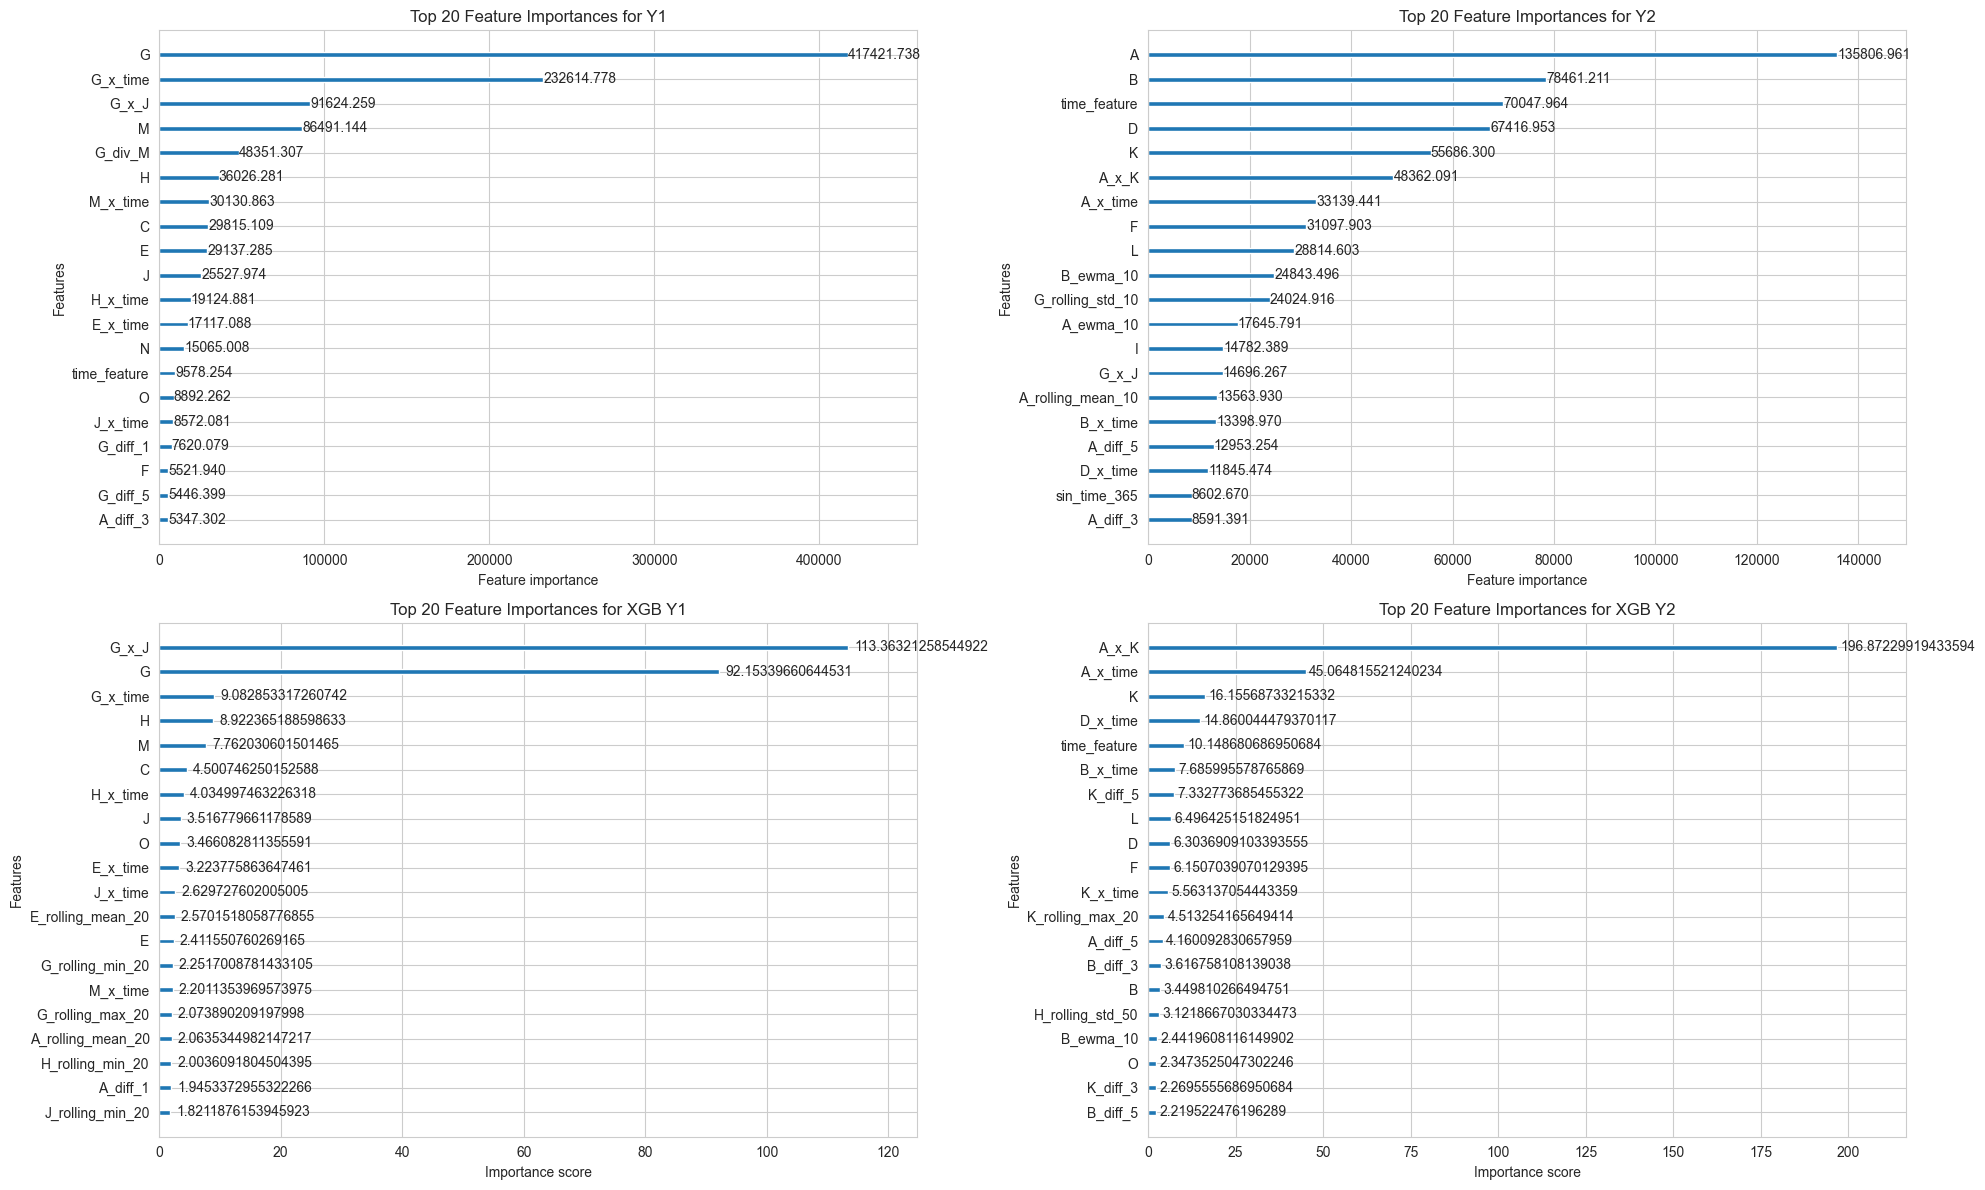

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# Plot on the first subplot (top-left)
lgb.plot_importance(final_model_y1, 
                    max_num_features=20, 
                    importance_type='gain', 
                    title='Top 20 Feature Importances for Y1', 
                    ax=axes[0, 0]) # Pass the specific axis

# Plot on the second subplot (top-right)
lgb.plot_importance(final_model_y2, 
                    max_num_features=20, 
                    importance_type='gain', 
                    title='Top 20 Feature Importances for Y2', 
                    ax=axes[0, 1]) # Pass the specific axis

# Plot on the third subplot (bottom-left)
xgb.plot_importance(final_xgb_y1, 
                    max_num_features=20, 
                    importance_type='gain', 
                    title='Top 20 Feature Importances for XGB Y1',
                    ax=axes[1, 0]) # Pass the specific axis

# Plot on the fourth subplot (bottom-right)
xgb.plot_importance(final_xgb_y2, 
                    max_num_features=20, 
                    importance_type='gain', 
                    title='Top 20 Feature Importances for XGB Y2',
                    ax=axes[1, 1]) # Pass the specific axis

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()
plt.show()

In [ ]:
def create_features(df):
    df_featured = df.copy()
    original_features = [col for col in df.columns if col not in ['time', 'id', 'Y1', 'Y2']]
    momentum_features = ['A', 'K', 'B', 'G', 'M', 'J']
    rolling_features = ['A', 'B', 'G', 'K', 'M', 'J', 'E', 'H', 'D', 'I']

    for col in original_features:
        df_featured[f'{col}_lag_1'] = df_featured[col].shift(1)

    for col in momentum_features:
        for lag in [1, 3, 5]:
            df_featured[f'{col}_diff_{lag}'] = df_featured[col].diff(lag)

    for window in [10, 20, 50]:
        for col in rolling_features:
            df_featured[f'{col}_rolling_mean_{window}'] = df_featured[col].rolling(window=window).mean()
            df_featured[f'{col}_rolling_std_{window}'] = df_featured[col].rolling(window=window).std()
            if window == 20:
                df_featured[f'{col}_rolling_max_{window}'] = df_featured[col].rolling(window=window).max()
                df_featured[f'{col}_rolling_min_{window}'] = df_featured[col].rolling(window=window).min()

    for col in rolling_features:
        for span in [10, 50]:
             df_featured[f'{col}_ewma_{span}'] = df_featured[col].ewm(span=span, adjust=False).mean()

    epsilon = 1e-6
    df_featured['G_div_M'] = df_featured['G'] / (df_featured['M'] + epsilon)
    df_featured['G_x_J'] = df_featured['G'] * df_featured['J']
    df_featured['A_div_K'] = df_featured['A'] / (df_featured['K'] + epsilon)
    df_featured['A_x_K'] = df_featured['A'] * df_featured['K']

    df_featured['time_feature'] = df_featured['time']
    time_interaction_features = ['A', 'K', 'B', 'G', 'M', 'E', 'J', 'H', 'D', 'I']
    if 'time_feature' in df_featured.columns:
        for col in time_interaction_features:
            df_featured[f'{col}_x_time'] = df_featured[col] * df_featured['time_feature']

    return df_featured

combined_df = pd.concat([train_df.drop(['Y1', 'Y2'], axis=1), test_df], ignore_index=True)
combined_featured_df = create_features(combined_df)

train_featured_df = combined_featured_df.iloc[:len(train_df)]
test_featured_df = combined_featured_df.iloc[len(train_df):]

train_featured_df['Y1'] = train_df['Y1'].values
train_featured_df['Y2'] = train_df['Y2'].values

train_featured_df.fillna(train_featured_df.median(), inplace=True)
test_featured_df.fillna(test_featured_df.median(), inplace=True)

print("Shape of featured training data:", train_featured_df.shape)
print("Shape of featured test data:", test_featured_df.shape)
train_featured_df.head()

In [79]:
print("Making predictions on the test set with the ensemble model...")

# Predict with both the LightGBM and XGBoost models for Y1
lgbm_preds_y1_final = final_model_y1.predict(X_test)
xgb_preds_y1_final = final_xgb_y1.predict(X_test)

# Predict with both the LightGBM and XGBoost models for Y2
lgbm_preds_y2_final = final_model_y2.predict(X_test)
xgb_preds_y2_final = final_xgb_y2.predict(X_test)

# --- Create the ensemble prediction by averaging the model outputs ---
# The weights (0.5/0.5) should match what you used in validation.
predictions_y1 = (lgbm_preds_y1_final * 0.5) + (xgb_preds_y1_final * 0.5)
predictions_y2 = (lgbm_preds_y2_final * 0.5) + (xgb_preds_y2_final * 0.5)

print("Predictions complete.")

# --- Create the submission file ---
# Assuming 'test_df' is your original test DataFrame with the 'id' column
submission = pd.DataFrame({
    'id': test_df['id'],
    'Y1': predictions_y1,
    'Y2': predictions_y2
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")
submission.head()

Making predictions on the test set with the ensemble model...
Predictions complete.

Submission file created successfully!


,id,Y1,Y2
0,1,0.527023,-0.178449
1,2,-0.229193,-0.289977
2,3,-0.287211,-0.081688
3,4,-0.389023,0.101872
4,5,-0.899309,0.095089


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import numpy as np

# Make sure X, y1, and y2 are defined from your feature engineering and data prep steps

# --- 1. Hyperparameter Tuning for Y1 with Optuna ---

def objective_y1(trial):
    """Define the objective function for Optuna to optimize for Y1."""
    # Define the search space for hyperparameters
    params = {
        'objective': 'regression_l1',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
    }

    # Use TimeSeriesSplit for validation within the trial
    tscv = TimeSeriesSplit(n_splits=3) # Use fewer splits for faster tuning
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y1_train,
                  eval_set=[(X_val, y1_val)],
                  eval_metric='r2',
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        
        preds = model.predict(X_val)
        scores.append(r2_score(y1_val, preds))

    return np.mean(scores)

# Run the optimization for Y1
print("--- Starting Hyperparameter Tuning for Y1 ---")
study_y1 = optuna.create_study(direction='maximize')
study_y1.optimize(objective_y1, n_trials=50) # Run 50 trials
best_params_y1 = study_y1.best_params
print(f"Best R2 for Y1: {study_y1.best_value}")
print("Best hyperparameters for Y1 found.")


# --- 2. Hyperparameter Tuning for Y2 with Optuna ---

def objective_y2(trial):
    """Define the objective function for Optuna to optimize for Y2."""
    params = {
        'objective': 'regression_l1',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y2_train,
                  eval_set=[(X_val, y2_val)],
                  eval_metric='r2',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        preds = model.predict(X_val)
        scores.append(r2_score(y2_val, preds))

    return np.mean(scores)

# Run the optimization for Y2
print("\n--- Starting Hyperparameter Tuning for Y2 ---")
study_y2 = optuna.create_study(direction='maximize')
study_y2.optimize(objective_y2, n_trials=50) # Run 50 trials
best_params_y2 = study_y2.best_params
print(f"Best R2 for Y2: {study_y2.best_value}")
print("Best hyperparameters for Y2 found.")


# --- 3. Final Validation with Best Hyperparameters ---
print("\n--- Running final validation with tuned hyperparameters ---")
# Combine best params with fixed ones
final_params_y1 = {'objective': 'regression_l1', 'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt', **best_params_y1}
final_params_y2 = {'objective': 'regression_l1', 'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt', **best_params_y2}


tscv_final = TimeSeriesSplit(n_splits=5)
scores_y1, scores_y2 = [], []

for fold, (train_index, val_index) in enumerate(tscv_final.split(X), 1):
    print(f"--- Fold {fold}/5 ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]
    y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

    # Train and evaluate for Y1
    model_y1 = lgb.LGBMRegressor(**final_params_y1)
    model_y1.fit(X_train, y1_train, eval_set=[(X_val, y1_val)], eval_metric='r2', callbacks=[lgb.early_stopping(100, verbose=False)])
    val_preds_y1 = model_y1.predict(X_val)
    r2_y1 = r2_score(y1_val, val_preds_y1)
    scores_y1.append(r2_y1)
    print(f"Y1 R² for fold {fold}: {r2_y1:.4f}")

    # Train and evaluate for Y2
    model_y2 = lgb.LGBMRegressor(**final_params_y2)
    model_y2.fit(X_train, y2_train, eval_set=[(X_val, y2_val)], eval_metric='r2', callbacks=[lgb.early_stopping(100, verbose=False)])
    val_preds_y2 = model_y2.predict(X_val)
    r2_y2 = r2_score(y2_val, val_preds_y2)
    scores_y2.append(r2_y2)
    print(f"Y2 R² for fold {fold}: {r2_y2:.4f}")

# --- Validation Summary ---
print("\n--- Validation Summary ---")
print(f"Average Y1 R²: {np.mean(scores_y1):.4f} +/- {np.std(scores_y1):.4f}")
print(f"Average Y2 R²: {np.mean(scores_y2):.4f} +/- {np.std(scores_y2):.4f}")
print(f"Expected Final Score: {np.mean((np.mean(scores_y1), np.mean(scores_y2))):.4f}")


[I 2025-09-22 01:18:24,977] A new study created in memory with name: no-name-085cb3bb-04d0-4ff0-a45c-dbe9d260cf27


--- Starting Hyperparameter Tuning for Y1 ---


[I 2025-09-22 01:18:43,952] Trial 0 finished with value: 0.7106918978435978 and parameters: {'n_estimators': 981, 'learning_rate': 0.017222497293133455, 'feature_fraction': 0.8110096563045206, 'bagging_fraction': 0.6718090075480441, 'bagging_freq': 5, 'lambda_l1': 0.009750198760321158, 'lambda_l2': 2.2831119831416853e-07, 'num_leaves': 31}. Best is trial 0 with value: 0.7106918978435978.
[I 2025-09-22 01:19:07,524] Trial 1 finished with value: 0.7105642637546546 and parameters: {'n_estimators': 463, 'learning_rate': 0.037702578587547025, 'feature_fraction': 0.7741435868037992, 'bagging_fraction': 0.6745627632478683, 'bagging_freq': 5, 'lambda_l1': 0.28010138713763205, 'lambda_l2': 0.00023503003820042173, 'num_leaves': 88}. Best is trial 0 with value: 0.7106918978435978.
[I 2025-09-22 01:19:11,436] Trial 2 finished with value: 0.6724718415284383 and parameters: {'n_estimators': 119, 'learning_rate': 0.03218370934534932, 'feature_fraction': 0.7534165185225947, 'bagging_fraction': 0.93043

Best R2 for Y1: 0.7153233326647438
Best hyperparameters for Y1 found.

--- Starting Hyperparameter Tuning for Y2 ---


[I 2025-09-22 01:34:16,054] Trial 0 finished with value: 0.6591109821141647 and parameters: {'n_estimators': 960, 'learning_rate': 0.05514567544505985, 'feature_fraction': 0.9850757672724888, 'bagging_fraction': 0.7199012956075888, 'bagging_freq': 7, 'lambda_l1': 2.02438903982476, 'lambda_l2': 4.8806640066701734e-05, 'num_leaves': 44}. Best is trial 0 with value: 0.6591109821141647.
[I 2025-09-22 01:34:25,436] Trial 1 finished with value: 0.6644009359596391 and parameters: {'n_estimators': 806, 'learning_rate': 0.06971946859195054, 'feature_fraction': 0.9791208564507825, 'bagging_fraction': 0.9644335354939224, 'bagging_freq': 6, 'lambda_l1': 1.6008170405891366e-07, 'lambda_l2': 0.001616616668356328, 'num_leaves': 32}. Best is trial 1 with value: 0.6644009359596391.
[I 2025-09-22 01:34:46,746] Trial 2 finished with value: 0.6554709276848413 and parameters: {'n_estimators': 824, 'learning_rate': 0.038804602079607294, 'feature_fraction': 0.7614720947966311, 'bagging_fraction': 0.707394840

Best R2 for Y2: 0.67698032567393
Best hyperparameters for Y2 found.

--- Running final validation with tuned hyperparameters ---
--- Fold 1/5 ---


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [44]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import numpy as np

# Make sure X, y1, and y2 are defined from your feature engineering and data prep steps

# --- 1. Hyperparameter Tuning for Y1 with Optuna ---

def objective_y1(trial):
    """Define the objective function for Optuna to optimize for Y1."""
    # Define the search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    # Use TimeSeriesSplit for validation within the trial
    tscv = TimeSeriesSplit(n_splits=3) # Use fewer splits for faster tuning
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]

        model = xgb.XGBRegressor(callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)], **params)
        model.fit(X_train, y1_train,
                  eval_set=[(X_val, y1_val)], verbose=False)
        
        preds = model.predict(X_val)
        scores.append(r2_score(y1_val, preds))

    return np.mean(scores)

# Run the optimization for Y1
print("--- Starting Hyperparameter Tuning for Y1 ---")
study_y1 = optuna.create_study(direction='maximize')
study_y1.optimize(objective_y1, n_trials=40) # Run 50 trials
best_params_y1 = study_y1.best_params
print(f"Best R2 for Y1: {study_y1.best_value}")
print("Best hyperparameters for Y1 found.")


# --- 2. Hyperparameter Tuning for Y2 with Optuna ---

def objective_y2(trial):
    """Define the objective function for Optuna to optimize for Y2."""
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

        model = xgb.XGBRegressor(callbacks=[xgb.callback.EarlyStopping(rounds=100, save_best=True)], **params)
        model.fit(X_train, y2_train,
                  eval_set=[(X_val, y2_val)], verbose=False)

        preds = model.predict(X_val)
        scores.append(r2_score(y2_val, preds))

    return np.mean(scores)

# Run the optimization for Y2
print("\n--- Starting Hyperparameter Tuning for Y2 ---")
study_y2 = optuna.create_study(direction='maximize')
study_y2.optimize(objective_y2, n_trials=40) # Run 50 trials
best_params_y2 = study_y2.best_params
print(f"Best R2 for Y2: {study_y2.best_value}")
print("Best hyperparameters for Y2 found.")


# --- 3. Final Validation with Best Hyperparameters ---
print("\n--- Running final validation with tuned hyperparameters ---")
# Combine best params with fixed ones
final_xgb_params_y1 = {'objective': 'reg:squarederror', 'n_jobs': -1, 'seed': 42, **best_params_y1}
final_xgb_params_y2 = {'objective': 'reg:squarederror', 'n_jobs': -1, 'seed': 42, **best_params_y2}


tscv_final = TimeSeriesSplit(n_splits=5)
scores_y1, scores_y2 = [], []

for fold, (train_index, val_index) in enumerate(tscv_final.split(X), 1):
    print(f"--- Fold {fold}/5 ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]
    y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

    # Train and evaluate for Y1
    model_y1 = xgb.XGBRegressor(**final_xgb_params_y1)
    model_y1.fit(X_train, y1_train, eval_set=[(X_val, y1_val)], verbose=False)
    val_preds_y1 = model_y1.predict(X_val)
    r2_y1 = r2_score(y1_val, val_preds_y1)
    scores_y1.append(r2_y1)
    print(f"Y1 R² for fold {fold}: {r2_y1:.4f}")

    # Train and evaluate for Y2
    model_y2 = xgb.XGBRegressor(**final_xgb_params_y2)
    model_y2.fit(X_train, y2_train, eval_set=[(X_val, y2_val)], verbose=False)
    val_preds_y2 = model_y2.predict(X_val)
    r2_y2 = r2_score(y2_val, val_preds_y2)
    scores_y2.append(r2_y2)
    print(f"Y2 R² for fold {fold}: {r2_y2:.4f}")

# --- Validation Summary ---
print("\n--- Validation Summary ---")
print(f"Average Y1 R²: {np.mean(scores_y1):.4f} +/- {np.std(scores_y1):.4f}")
print(f"Average Y2 R²: {np.mean(scores_y2):.4f} +/- {np.std(scores_y2):.4f}")
print(f"Expected Final Score: {np.mean((np.mean(scores_y1), np.mean(scores_y2))):.4f}")

[I 2025-09-22 04:58:41,363] A new study created in memory with name: no-name-f18bc237-3c02-46b4-877d-8d8a2934b647


--- Starting Hyperparameter Tuning for Y1 ---


[I 2025-09-22 04:58:43,583] Trial 0 finished with value: 0.7160763716276493 and parameters: {'n_estimators': 1200, 'learning_rate': 0.04314349525499047, 'max_depth': 3, 'subsample': 0.7149705568563974, 'colsample_bytree': 0.9979330769815427, 'lambda': 0.09420260353095936, 'alpha': 3.28867143615483e-06}. Best is trial 0 with value: 0.7160763716276493.
[I 2025-09-22 04:58:45,206] Trial 1 finished with value: 0.7135677609079686 and parameters: {'n_estimators': 500, 'learning_rate': 0.03422318852820636, 'max_depth': 3, 'subsample': 0.7611239967042358, 'colsample_bytree': 0.772799800390804, 'lambda': 3.5432629297315093e-07, 'alpha': 2.385076304704633e-05}. Best is trial 0 with value: 0.7160763716276493.
[I 2025-09-22 04:58:47,688] Trial 2 finished with value: 0.7155327621821205 and parameters: {'n_estimators': 1300, 'learning_rate': 0.023372942856744277, 'max_depth': 3, 'subsample': 0.8661116257068328, 'colsample_bytree': 0.7144054204764949, 'lambda': 0.04812985622367597, 'alpha': 0.0006634

Best R2 for Y1: 0.7225579937934397
Best hyperparameters for Y1 found.

--- Starting Hyperparameter Tuning for Y2 ---


[I 2025-09-22 05:00:36,028] Trial 0 finished with value: 0.6734881346952061 and parameters: {'n_estimators': 900, 'learning_rate': 0.059522408955598016, 'max_depth': 9, 'subsample': 0.870844460113031, 'colsample_bytree': 0.9326329116225873, 'lambda': 3.469583119496554e-05, 'alpha': 1.716314273588761e-07}. Best is trial 0 with value: 0.6734881346952061.
[I 2025-09-22 05:00:38,027] Trial 1 finished with value: 0.6806777370433661 and parameters: {'n_estimators': 1300, 'learning_rate': 0.08342943198623892, 'max_depth': 6, 'subsample': 0.8662708986584474, 'colsample_bytree': 0.9609476635127931, 'lambda': 8.444485393925546e-06, 'alpha': 6.882731569076204e-06}. Best is trial 1 with value: 0.6806777370433661.
[I 2025-09-22 05:00:42,702] Trial 2 finished with value: 0.6877050505315997 and parameters: {'n_estimators': 1600, 'learning_rate': 0.018840126981512318, 'max_depth': 6, 'subsample': 0.960752576440397, 'colsample_bytree': 0.7680490751625958, 'lambda': 0.07514445706189145, 'alpha': 0.01404

Best R2 for Y2: 0.697470934595406
Best hyperparameters for Y2 found.

--- Running final validation with tuned hyperparameters ---
--- Fold 1/5 ---
Y1 R² for fold 1: 0.6357
Y2 R² for fold 1: -0.0890
--- Fold 2/5 ---
Y1 R² for fold 2: 0.6700
Y2 R² for fold 2: 0.6196
--- Fold 3/5 ---
Y1 R² for fold 3: 0.7568
Y2 R² for fold 3: 0.6585
--- Fold 4/5 ---
Y1 R² for fold 4: 0.7748
Y2 R² for fold 4: 0.7380
--- Fold 5/5 ---
Y1 R² for fold 5: 0.7081
Y2 R² for fold 5: 0.6407

--- Validation Summary ---
Average Y1 R²: 0.7091 +/- 0.0520
Average Y2 R²: 0.5136 +/- 0.3039
Expected Final Score: 0.6113
